## Иногда в предыдущих упражнениях мы игнорировали project1 в наших расчетах. Проект был соревновательным. У него были более длительные сроки и гораздо больше коммитов, чем у обычных лаб. Давайте посмотрим динамику коммитов в этом проекте на пользователя.
## На этот раз мы будем использовать другую библиотеку для визуализации данных на Python – Seaborn. В общем, в этой библиотеке гораздо проще создать что-то красивое.

In [166]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


conn = sqlite3.connect('../data/checking-logs.sqlite')

In [167]:
query = """
SELECT timestamp, uid
FROM checker
WHERE uid LIKE 'user_%' AND status = 'ready' AND labname = 'project1';
"""
df = pd.read_sql_query(query, conn)
df['date'] = pd.to_datetime(df['timestamp']).dt.date
df.drop('timestamp', axis=True, inplace=True)

df_commits_counts = df.value_counts().reset_index().sort_values(by='date')
df_commits_counts['cumsum_commits'] = df_commits_counts.groupby(by=['uid'])['count'].cumsum()
df_commits_counts.drop('count', axis=1).head()

,uid,date,cumsum_commits
43,user_4,2020-04-17,7
90,user_17,2020-04-18,1
51,user_4,2020-04-19,11
88,user_30,2020-04-22,1
93,user_30,2020-04-23,2


In [168]:
additional_rows = []
for user in df_commits_counts['uid'].unique():
    user_data = df_commits_counts[df_commits_counts['uid'] == user]
    first_date = user_data['date'].min()  # Первая дата
    previous_date = first_date - pd.Timedelta(days=1)  # Предыдущая дата
    additional_rows.append({'uid': user, 'date': previous_date, 'count': 0, 'cumsum_commits': 0})

additional_df = pd.DataFrame(additional_rows)
df_combined = pd.concat([df_commits_counts, additional_df], ignore_index=True).sort_values(by=['uid', 'date'])

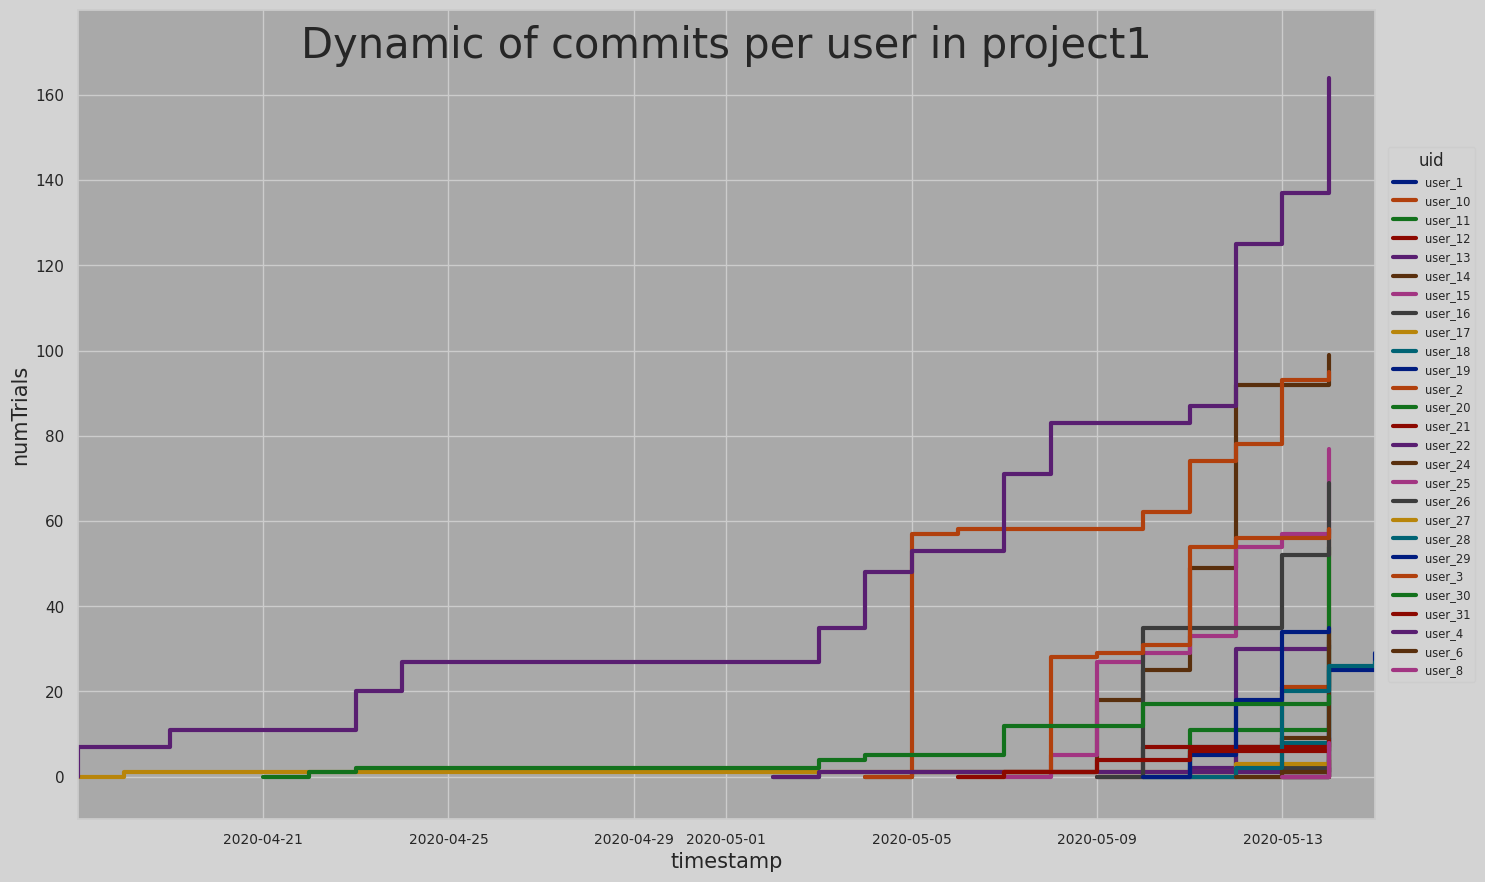

In [169]:
fig, ax = plt.subplots(figsize=(15, 10))
fig.set_facecolor('lightgray')
ax.set_facecolor('darkgray')

# Стиль Seaborn
sns.set_theme(style="whitegrid")

# Палитра цветов
palette = sns.color_palette("dark")

# Построение графиков для каждого пользователя
for i, user in enumerate(df_combined.uid.unique()):
    user_data = df_combined[df_combined['uid'] == user]
    ax.step(data=user_data, x='date', y='cumsum_commits', where="post", linewidth=3, 
            label=user, color=palette[i % len(palette)])

# Настройка заголовка и меток осей
ax.set_title('Dynamic of commits per user in project1', fontsize=30, y = 0.93)
ax.set_xlabel('timestamp', fontsize=15)
ax.set_ylabel('numTrials', fontsize=15)
yticks = range(0, 181, 20)
ax.set_yticks(yticks[:-1])  # Исключаем последнюю метку
ax.set_ylim(10, yticks[-1])  # Устанавливаем границы оси Y (исключаем последнюю метку)
#ax.set_yticks(yticks)
ax.set_ylim(-10, yticks[-1]) # Устанавливаем нижнюю границу оси Y ниже нуля

# Убираем первую метку на оси X
current_xticks = ax.get_xticks()
current_labels = ax.get_xticklabels()
ax.set_xticks(current_xticks[1:])
ax.set_xticklabels([label.get_text() for label in current_labels[1:]], ha='center', fontsize=10)

# Установка границ оси X
ax.set_xlim(df_combined['date'].min() + pd.Timedelta(days=1), df_combined['date'].max())

# Настройка легенды
legend = ax.legend(title='uid', bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0.0, facecolor='lightgray', fontsize='x-small')

plt.subplots_adjust(bottom=0.5)

plt.tight_layout()
plt.show()

«Какой пользователь был лидером по количеству коммитов почти все время?» 
Ответ: user_4.

«Какой пользователь был лидером только короткий промежуток времени?» 
Ответ: user_2.

In [170]:
conn.close()